In [3]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML
from matplotlib.colors import ListedColormap
import scipy.stats as stats

In [4]:
# Rulebook for preferential attachment and cluster assignment
def rulebook(life, cluster_ids, new_cluster_prob):
    # Kernel to sum 8 neighbors
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    kernel = np.flipud(kernel)


    new_life = life.copy()
    new_cluster_ids = cluster_ids.copy()
    
    # Calculate the number of active neighbors for each cell
    neighbors = convolve(life, kernel, mode='constant', cval=0)
    
    # Calculate activation probabilities based on number of active neighbors
    activation_probabilities = neighbors / 8.0
    new_active_cells = (np.random.random(life.shape) < activation_probabilities) & (life == 0)
    
    for x, y in zip(*np.where(new_active_cells)):
        # Get cluster IDs of neighboring cells
        neighbor_ids = cluster_ids[max(x-1, 0):min(x+2, 200), max(y-1, 0):min(y+2, 200)].ravel()
        neighbor_ids = neighbor_ids[neighbor_ids > 0]
        
        # Decide whether to create a new cluster or join an existing one
        if np.random.random() < new_cluster_prob:
            new_cluster_id = cluster_ids.max()
            new_cluster_ids[x, y] = new_cluster_id + 1
        elif neighbor_ids.size > 0:
            # Assign the majority neighbor's cluster ID to the cell
            new_cluster_ids[x, y] = np.bincount(neighbor_ids).argmax()
    
    # Update the life array based on newly activated cells
    new_life = new_life | new_active_cells.astype(np.uint8)
    return new_life, new_cluster_ids

MovieWriter ffmpeg unavailable; using Pillow instead.


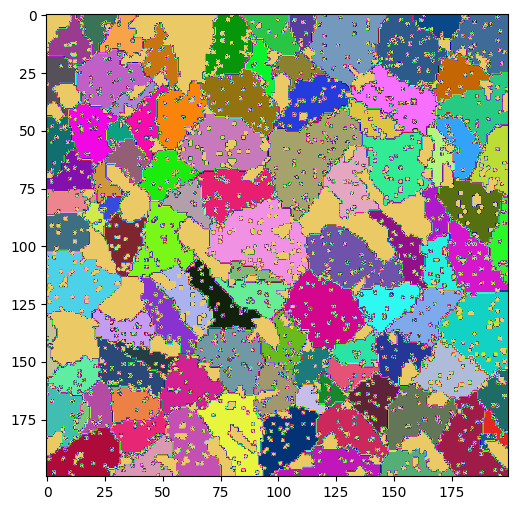

In [14]:
plt.rcParams["animation.html"] = "jshtml"

# Create a colormap with random colors for each cluster
colors = np.random.rand(200, 3)
colormap = ListedColormap(np.vstack([[0, 0, 0], colors]))

initial_cells_vals = [10, 50, 100, 250]
p_vals = [0.01, 0.05, 0.1, 0.2]

for i_cells in initial_cells_vals:
    for p_val in p_vals:
        # Initialize grid with multiple active cells
        grid = np.zeros((200, 200), dtype=np.uint8)
        cluster_ids = np.zeros((200, 200), dtype=np.int32)
        num_initial_cells = i_cells
        initial_positions = np.random.choice(200, (num_initial_cells, 2))
        for idx, (x, y) in enumerate(initial_positions):
            grid[x, y] = 1
            cluster_ids[x, y] = idx + 1

        # Initialize figure
        fig, ax = plt.subplots(figsize=(6, 6))
        im = ax.imshow(cluster_ids, cmap=colormap)

        # Animation function
        def animate(i):
            global grid, cluster_ids
            # Update the grid based on the rulebook
            grid, cluster_ids = rulebook(grid, cluster_ids, p_val)
            im.set_array(cluster_ids)
            return [im]

        # Animation details
        fps = 30
        anim = FuncAnimation(fig, animate, frames=10*fps, interval=1000/fps)
        anim.save(f'gifs/preferential_attachment_clusters_colored_rulebook_{i_cells}_{p_val}.gif', dpi=90)

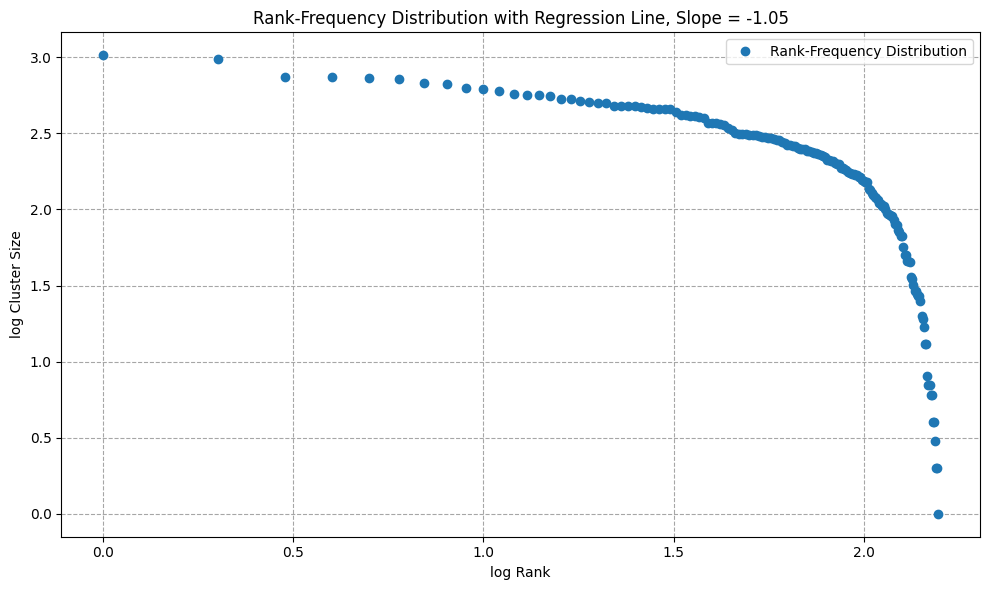

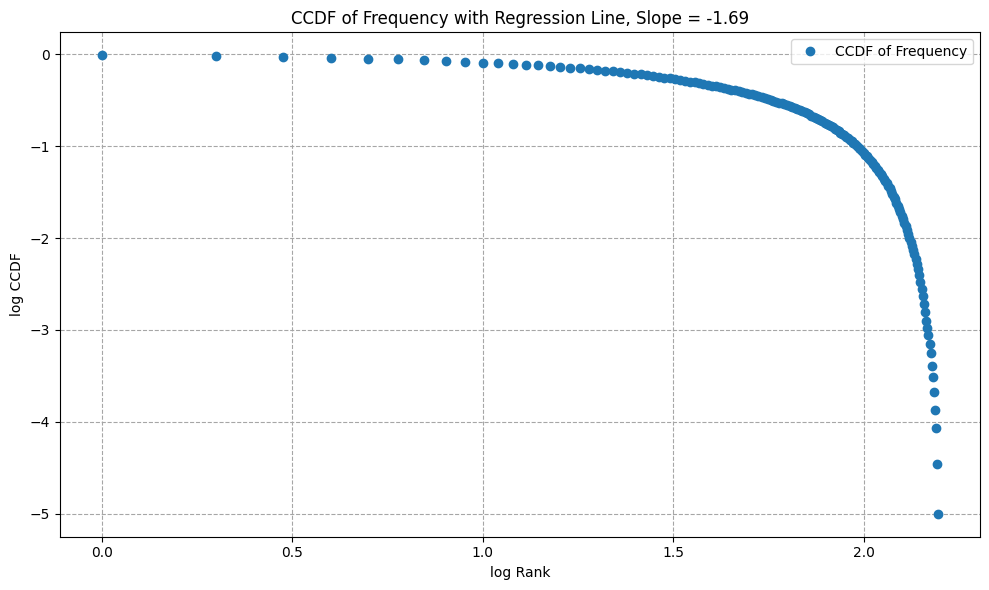

In [15]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Dummy data (you probably already have this in your code)
unique, counts = np.unique(cluster_ids[cluster_ids > 0], return_counts=True)
sorted_counts = sorted(counts)[::-1]

# Find the breakpoint (in this case, the median rank)
breakpoint = len(sorted_counts) // 2

# Separate data into two regions
x1 = np.log10(np.arange(1, breakpoint + 1))
y1 = np.log10(sorted_counts[:breakpoint])
x2 = np.log10(np.arange(breakpoint + 1, len(sorted_counts) + 1))
y2 = np.log10(sorted_counts[breakpoint:])

# Linear regressions for the two regions
slope1, intercept1, _, _, _ = stats.linregress(x1, y1)
slope2, intercept2, _, _, _ = stats.linregress(x2, y2)

# Plotting the rank-frequency distribution with piecewise regressions
plt.figure(figsize=(10, 6))
plt.plot(np.log10(np.arange(1, len(sorted_counts) + 1)), np.log10(sorted_counts), 'o', label='Rank-Frequency Distribution')
plt.plot(x1, slope1*x1 + intercept1, 'r', label=f'Regression 1, Slope = {slope1:.2f}')
plt.plot(x2, slope2*x2 + intercept2, 'g', label=f'Regression 2, Slope = {slope2:.2f}')
plt.xlabel('log Rank')
plt.ylabel('log Cluster Size')
plt.title('Rank-Frequency Distribution with Piecewise Regression Lines')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.savefig('rank_frequency_distribution_piecewise.png')
plt.show()

ccdf = 1 - np.cumsum(sorted_counts)/sum(sorted_counts)
ccdf += 1e-10
# Piecewise regression for the CCDF plot (similarly done as above)
x1 = np.log10(np.arange(1, breakpoint + 1))
y1 = np.log10(ccdf[:breakpoint])
x2 = np.log10(np.arange(breakpoint + 1, len(sorted_counts) + 1))
y2 = np.log10(ccdf[breakpoint:])
slope1, intercept1, _, _, _ = stats.linregress(x1, y1)
slope2, intercept2, _, _, _ = stats.linregress(x2, y2)

# Plotting the CCDF with piecewise regressions
plt.figure(figsize=(10, 6))
plt.plot(np.log10(np.arange(1, len(sorted_counts) + 1)), np.log10(ccdf), 'o', label='CCDF of Frequency')
plt.plot(x1, slope1*x1 + intercept1, 'r', label=f'Regression 1, Slope = {slope1:.2f}')
plt.plot(x2, slope2*x2 + intercept2, 'g', label=f'Regression 2, Slope = {slope2:.2f}')
plt.xlabel('log Rank')
plt.ylabel('log CCDF')
plt.title('CCDF of Frequency with Piecewise Regression Lines')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.savefig('ccdf_frequency_piecewise.png')
plt.show()


In [76]:
initial_cells_vals = [10, 50, 100, 250]
p_vals = [0.01, 0.05, 0.1, 0.2]
num_regressions = 10

coeffs = []

for _ in range(num_regressions):   
    for i_cells in initial_cells_vals:
        for p_val in p_vals:
            # Initialize grid with multiple active cells
            grid = np.zeros((200, 200), dtype=np.uint8)
            cluster_ids = np.zeros((200, 200), dtype=np.int32)
            num_initial_cells = i_cells
            initial_positions = np.random.choice(200, (num_initial_cells, 2))
            for idx, (x, y) in enumerate(initial_positions):
                grid[x, y] = 1
                cluster_ids[x, y] = idx + 1

            steps = 300
            for _ in range(steps):
                # Update the grid based on the rulebook
                grid, cluster_ids = rulebook(grid, cluster_ids, p_val)

            # Dummy data (you probably already have this in your code)
            unique, counts = np.unique(cluster_ids[cluster_ids > 0], return_counts=True)
            sorted_counts = sorted(counts)[::-1]

            # Find the breakpoint (in this case, the median rank)
            breakpoint = len(sorted_counts) // 2

            # Separate data into two regions
            x1 = np.log10(np.arange(1, breakpoint + 1))
            y1 = np.log10(sorted_counts[:breakpoint])
            x2 = np.log10(np.arange(breakpoint + 1, len(sorted_counts) + 1))
            y2 = np.log10(sorted_counts[breakpoint:])

            # Linear regressions for the two regions
            slope1, intercept1, _, _, _ = stats.linregress(x1, y1)
            slope2, intercept2, _, _, _ = stats.linregress(x2, y2)

            coeffs.append([float(slope1), float(slope2), p_val, i_cells, 0])

            ccdf = 1 - np.cumsum(sorted_counts)/sum(sorted_counts)
            ccdf += 1e-10
            # Piecewise regression for the CCDF plot (similarly done as above)
            x1 = np.log10(np.arange(1, breakpoint + 1))
            y1 = np.log10(ccdf[:breakpoint])
            x2 = np.log10(np.arange(breakpoint + 1, len(sorted_counts) + 1))
            y2 = np.log10(ccdf[breakpoint:])
            slope1, intercept1, _, _, _ = stats.linregress(x1, y1)
            slope2, intercept2, _, _, _ = stats.linregress(x2, y2)

            coeffs.append([float(slope1), float(slope2), p_val, i_cells, 1])



In [80]:
coeffs = np.array(coeffs)
coeffs

array([[-2.32605938e+00, -1.58816203e+00,  1.00000000e-02,
         1.00000000e+01,  0.00000000e+00],
       [-1.36600123e+00, -5.94509163e+00,  1.00000000e-02,
         1.00000000e+01,  1.00000000e+00],
       [-1.49486020e+00, -5.92194268e+00,  5.00000000e-02,
         1.00000000e+01,  0.00000000e+00],
       ...,
       [-3.78762460e-01, -9.84656078e+00,  1.00000000e-01,
         2.50000000e+02,  1.00000000e+00],
       [-7.55327722e-01, -3.64720690e+00,  2.00000000e-01,
         2.50000000e+02,  0.00000000e+00],
       [-4.67970627e-01, -8.74940636e+00,  2.00000000e-01,
         2.50000000e+02,  1.00000000e+00]])

In [81]:
coeffs_z = [c for c in coeffs if c[4] == 0]
coeffs_p = [c for c in coeffs if c[4] == 1]

In [88]:
from collections import defaultdict
grouped_zipf = defaultdict(list)
for row in coeffs_z:
    key = (row[2], row[3])
    grouped_zipf[key].append(row)

averages = []

for key, group in grouped_zipf.items():
    avg_first_column = sum(row[0] for row in group) / len(group)
    avg_second_column = sum(row[1] for row in group) / len(group)
    averages.append([avg_first_column, avg_second_column, key[0], key[1]])

# Print the averages
for avg in averages:
    print(avg)

[-2.4457638873721064, -2.231293787263195, 0.01, 10.0]
[-1.5372321661209736, -4.851414461997827, 0.05, 10.0]
[-1.0027247130693788, -5.9910392392205924, 0.1, 10.0]
[-0.5523064005885718, -6.102671721256636, 0.2, 10.0]
[-0.8245581776189119, -5.267770810338693, 0.01, 50.0]
[-0.6666005666028708, -7.315789969769907, 0.05, 50.0]
[-0.4576939959786711, -7.796504230738225, 0.1, 50.0]
[-0.4397990530585452, -6.667216002175249, 0.2, 50.0]
[-0.4057819325502822, -8.337458376439047, 0.01, 100.0]
[-0.40632731664291644, -7.038800894963211, 0.05, 100.0]
[-0.35222108999767693, -6.350699923874329, 0.1, 100.0]
[-0.609597093159579, -5.575274494192015, 0.2, 100.0]
[-0.33114733829751575, -5.36822824847488, 0.01, 250.0]
[-0.32738991432749687, -4.716292350485849, 0.05, 250.0]
[-0.4605051716286891, -4.409571484302406, 0.1, 250.0]
[-0.7368484381361856, -4.271091238002846, 0.2, 250.0]


In [89]:
grouped_power = defaultdict(list)
for row in coeffs_p:
    key = (row[2], row[3])
    grouped_power[key].append(row)

averages = []

for key, group in grouped_power.items():
    avg_first_column = sum(row[0] for row in group) / len(group)
    avg_second_column = sum(row[1] for row in group) / len(group)
    averages.append([avg_first_column, avg_second_column, key[0], key[1]])

# Print the averages
for avg in averages:
    print(avg)

[-1.565155539898972, -6.649361761650944, 0.01, 10.0]
[-1.0368342058727718, -8.86015286703602, 0.05, 10.0]
[-0.8039824050094359, -9.911586002693813, 0.1, 10.0]
[-0.617747067602744, -10.188823707659648, 0.2, 10.0]
[-1.1967986965369524, -9.138843404980793, 0.01, 50.0]
[-0.7393448598120307, -11.414665078475945, 0.05, 50.0]
[-0.555988965184553, -12.202068497966719, 0.1, 50.0]
[-0.5347161636419953, -11.741986527012905, 0.2, 50.0]
[-0.5755842583659054, -11.852886313088206, 0.01, 100.0]
[-0.46579900517496037, -12.1916526412632, 0.05, 100.0]
[-0.4314212890460955, -11.617942098601787, 0.1, 100.0]
[-0.5219817361756127, -11.019713755489972, 0.2, 100.0]
[-0.3848354196585001, -10.418908303802977, 0.01, 250.0]
[-0.36758378322899105, -9.929396455077269, 0.05, 250.0]
[-0.38938378930229467, -9.651700656114718, 0.1, 250.0]
[-0.45426589316488747, -9.333412634288537, 0.2, 250.0]
